In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from dbscan_cluster import run_dbscan
from cluster_utils import cluster_plot, cluster_plot_galactic
import json

from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u
from simbad_download import resolve_name
from uncertainties import unumpy, ufloat
from sklearn.preprocessing import StandardScaler

In [2]:
CLUSTER_NAME: str = 'King 11'

In [3]:
gaiadr3 = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}.csv')
normalized = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized.dat')
uncert = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_uncert.dat')
normalized_cp = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_cp.dat')
uncert_cp = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_cp_uncert.dat')
lit = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_literature.csv')

In [4]:
lit_dr3 = pd.merge(left=lit[['EDR3 id', 'reported', 'TIC']], right=gaiadr3, left_on='EDR3 id', right_on='source_id', how='inner')

In [68]:
cp_ra, cp_dec, cp_par, cp_pmra, cp_pmdec, cp_radvel = resolve_name(CLUSTER_NAME)

In [6]:
galactic_coords = SkyCoord(ra=cp_ra*u.deg, dec=cp_dec*u.deg,
                           pm_ra_cosdec=cp_pmra*u.mas/u.year, frame=ICRS,
                           pm_dec=cp_pmdec*u.mas/u.year).galactic

In [7]:
galactic_coords

<SkyCoord (Galactic): (l, b) in deg
    (117.15039535, 6.48328308)
 (pm_l_cosb, pm_b) in mas / yr
    (-3.41296441, 0.20319192)>

# Plain DBSCAN

In [8]:
with open(f'optuna_db/{CLUSTER_NAME}/{CLUSTER_NAME.replace(" ", "_")}_best_params.json', 'r') as f:
    best_params = json.load(f)

In [9]:
best_params

{'best_value': 0.41868329585948516,
 'best_params': {'eps': 0.07734465367734741, 'min_samples': 11}}

In [10]:
uncert

array([[0.04654897, 0.14608363, 0.56147708, 0.03399773, 0.06637208],
       [0.17028208, 0.36977884, 1.78669656, 0.12637852, 0.16094281],
       [0.08643806, 0.20378214, 0.96918569, 0.07312107, 0.09915111],
       ...,
       [0.10064574, 0.22116584, 1.14011362, 0.08488548, 0.09428179],
       [0.70933904, 1.59891047, 6.62483392, 0.76819069, 0.73140662],
       [0.20585761, 0.41634846, 2.14645312, 0.15100047, 0.17583198]])

In [46]:
clustered, noise, found, not_found = run_dbscan(normalized, gaiadr3, lit_dr3, 0.12, 7, False)

Classified into 6 labels.
Clustered: 87/121
87/121 sources from literature clustered
301 clustered sources.


In [51]:
clustered_sets = []
noise_sets = []
found_sets = []
not_found_sets = []

for _ in range(20):
    normalized_u = normalized + np.random.normal(scale=np.abs(uncert), size=normalized.shape)
    clustered, noise, found, not_found = run_dbscan(normalized_u, gaiadr3, lit_dr3, 0.15, 5, False)
    clustered_sets.append(clustered)
    noise_sets.append(noise)
    found_sets.append(found)
    not_found_sets.append(not_found)

Classified into 5 labels.
Clustered: 86/121
86/121 sources from literature clustered
231 clustered sources.
Classified into 9 labels.
Clustered: 82/121
82/121 sources from literature clustered
182 clustered sources.
Classified into 8 labels.
Clustered: 82/121
82/121 sources from literature clustered
202 clustered sources.
Classified into 8 labels.
Clustered: 79/121
79/121 sources from literature clustered
196 clustered sources.
Classified into 8 labels.
Clustered: 85/121
85/121 sources from literature clustered
193 clustered sources.
Classified into 8 labels.
Clustered: 81/121
81/121 sources from literature clustered
190 clustered sources.
Classified into 9 labels.
Clustered: 83/121
83/121 sources from literature clustered
226 clustered sources.
Classified into 11 labels.
Clustered: 75/121
75/121 sources from literature clustered
182 clustered sources.
Classified into 7 labels.
Clustered: 88/121
88/121 sources from literature clustered
217 clustered sources.
Classified into 8 labels.
C

In [52]:
clustered = pd.concat(clustered_sets).drop_duplicates(subset=['source_id'])
len(clustered)

716

In [53]:
found = pd.concat(found_sets).drop_duplicates(subset=['source_id'])
len(found)

120

In [56]:
not_found = pd.concat(not_found_sets).drop_duplicates(subset=['source_id'])
len(not_found)

92

In [57]:
clustered.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,A_y,A_J,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label
45,1636148068921376768,Gaia DR3 2214127933978738560,2214127933978738560,1638721893,2016.0,-3.532828,0.081749,68.630982,0.082653,0.256053,...,3.797841,2.383649,1.410283,0.909918,0.611004,0.034745,2.506536,0.816695,0.153567,0
100,1636148068921376768,Gaia DR3 2214128384954802176,2214128384954802176,1797475658,2016.0,-3.400607,0.019176,68.607616,0.022509,0.293627,...,3.797841,2.383649,1.410283,0.909918,1.011096,0.002842,0.061857,0.184957,0.162418,0
109,1636148068921376768,Gaia DR3 2214128483733343232,2214128483733343232,336295249,2016.0,-3.346382,0.153488,68.62848,0.147758,0.170991,...,3.797841,2.383649,1.410283,0.909918,0.714081,0.055416,2.54786,2.271272,0.102951,0
115,1636148068921376768,Gaia DR3 2214128522394752512,2214128522394752512,1381386726,2016.0,-3.299702,0.071153,68.635789,0.073094,0.375539,...,3.680382,2.309928,1.366666,0.881776,0.992557,0.020631,3.130102,0.492188,0.151545,0
116,1636148068921376768,Gaia DR3 2214128552452820096,2214128552452820096,472368864,2016.0,-3.366423,0.019527,68.627336,0.020311,0.260835,...,3.797841,2.383649,1.410283,0.909918,1.00277,0.002911,-0.362961,0.196506,0.162326,0


In [58]:
occurences = clustered['source_id'].apply(lambda x:
                                          sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in clustered_sets]))

In [59]:
found['occurences'] = found['source_id'].apply(lambda x:
                                          sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in found_sets]))/20.0

In [60]:
not_found['occurences'] = 1.0-not_found['source_id'].apply(lambda x:
                                                       sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in not_found_sets]))/20.0

In [61]:
clustered['occurences'] = occurences/20.0
clustered.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,A_J,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label,occurences
45,1636148068921376768,Gaia DR3 2214127933978738560,2214127933978738560,1638721893,2016.0,-3.532828,0.081749,68.630982,0.082653,0.256053,...,2.383649,1.410283,0.909918,0.611004,0.034745,2.506536,0.816695,0.153567,0,0.15
100,1636148068921376768,Gaia DR3 2214128384954802176,2214128384954802176,1797475658,2016.0,-3.400607,0.019176,68.607616,0.022509,0.293627,...,2.383649,1.410283,0.909918,1.011096,0.002842,0.061857,0.184957,0.162418,0,0.65
109,1636148068921376768,Gaia DR3 2214128483733343232,2214128483733343232,336295249,2016.0,-3.346382,0.153488,68.62848,0.147758,0.170991,...,2.383649,1.410283,0.909918,0.714081,0.055416,2.54786,2.271272,0.102951,0,0.10
115,1636148068921376768,Gaia DR3 2214128522394752512,2214128522394752512,1381386726,2016.0,-3.299702,0.071153,68.635789,0.073094,0.375539,...,2.309928,1.366666,0.881776,0.992557,0.020631,3.130102,0.492188,0.151545,0,0.25
116,1636148068921376768,Gaia DR3 2214128552452820096,2214128552452820096,472368864,2016.0,-3.366423,0.019527,68.627336,0.020311,0.260835,...,2.383649,1.410283,0.909918,1.00277,0.002911,-0.362961,0.196506,0.162326,0,0.75


In [69]:
cp_coords = SkyCoord(ra=cp_ra*u.deg, dec=cp_dec*u.deg, frame=ICRS)
cp_ra = cp_coords.ra.wrap_at(180*u.deg).value

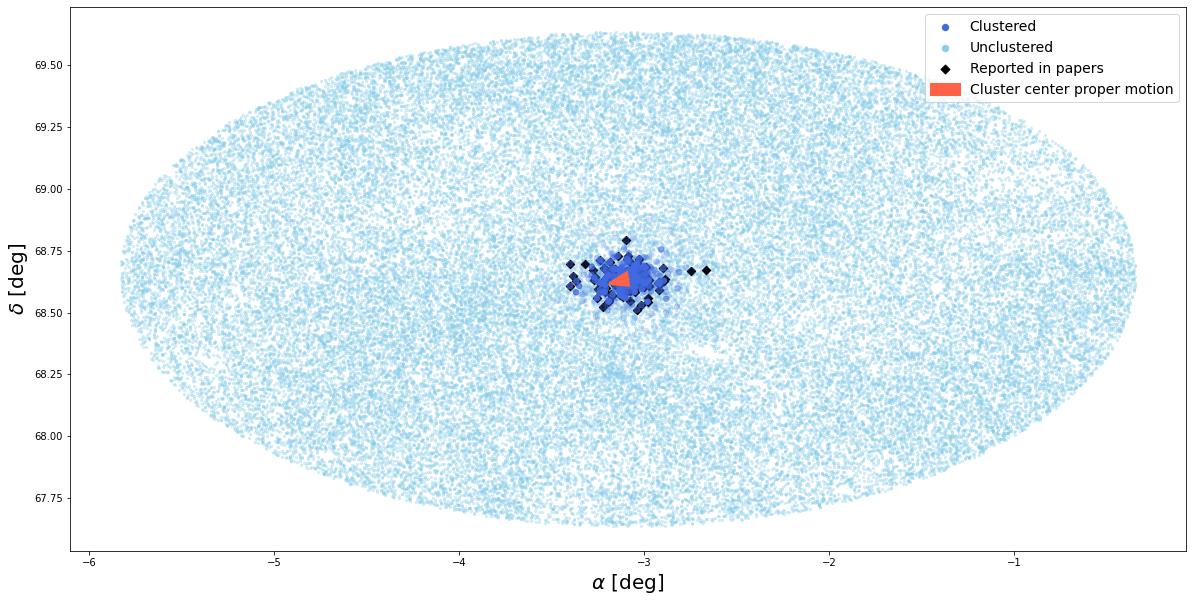

In [75]:
plt.figure(figsize=(20, 10))
plt.scatter(clustered.ra, clustered.dec, 
            color='royalblue', alpha=clustered.occurences, label='Clustered', zorder=2, s=30.)
plt.scatter(noise.ra, noise.dec, color='skyblue', label='Unclustered', zorder=1, s=5., alpha=.3)
plt.scatter(lit_dr3.ra, lit_dr3.dec, color='black', zorder=1,
            marker='D', label='Reported in papers')

plt.gca().set_xlabel('$\\alpha$ [deg]', fontsize=20);
plt.gca().set_ylabel('$\delta$ [deg]', fontsize=20);


plt.arrow(cp_ra,
          cp_dec,
          cp_pmra*(u.arcsec/u.year).to(u.deg/u.year),
          cp_pmdec*(u.arcsec/u.year).to(u.deg/u.year),
          linewidth=3.,
          color='tomato',
          head_width=0.05,
          head_length=0.1,
          zorder=4, label='Cluster center proper motion')

lgnd = plt.legend(fontsize=14, loc='upper right');
for handle in lgnd.legendHandles:
    handle._sizes = [40];
    handle._alpha = 1.;

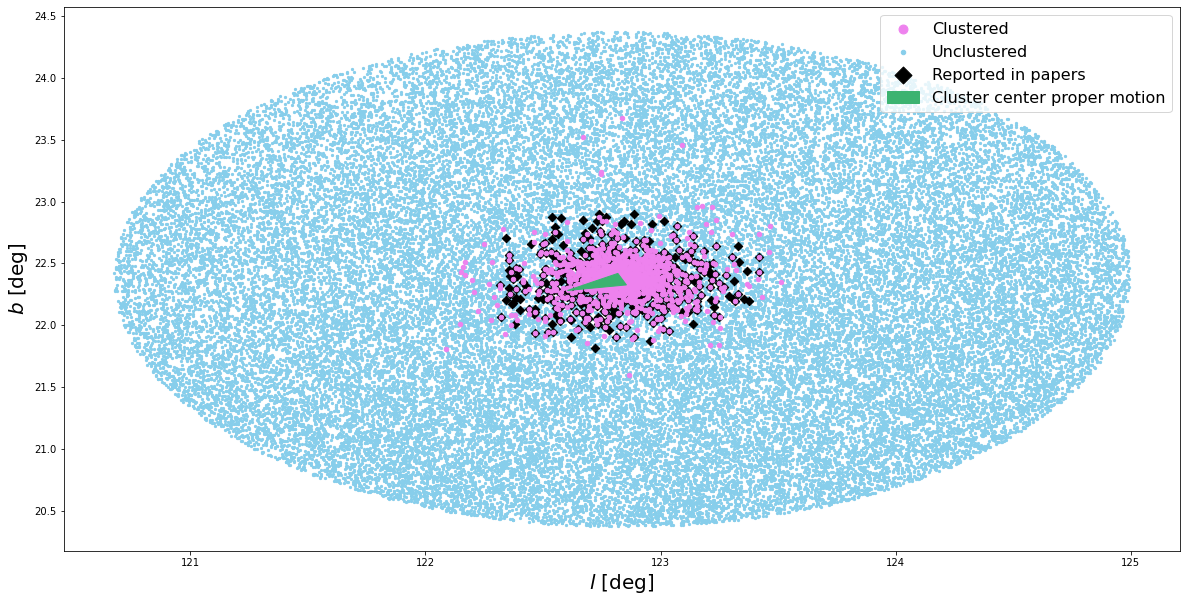

In [12]:
cluster_plot_galactic(clustered, gaiadr3, lit_dr3)
plt.arrow(galactic_coords.l.value,
          galactic_coords.b.value,
          galactic_coords.pm_l_cosb.to(u.deg/u.yr).value,
          galactic_coords.pm_b.to(u.deg/u.yr).value,
          linewidth=1.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.25,
          zorder=4,
          label='Cluster center proper motion')
plt.legend(fontsize=16, loc='upper right', markerscale=2.);

In [76]:
clustered.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_clustered.csv')
found.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_found.csv')
not_found.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_not_found.csv')

# Convergent velocities

In [13]:
with open(f'optuna_db/{CLUSTER_NAME}/{CLUSTER_NAME.replace(" ", "_")}_cp_best_params.json', 'r') as f:
    best_params = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'optuna_db/NGC 188/NGC_188_cp_best_params.json'

In [ ]:
best_params

In [28]:
clustered, noise, found, not_found = run_dbscan(normalized_cp, gaiadr3, lit_dr3, 0.025, 25, False)

Classified into 51 labels.
Clustered: 724/957
724/957 sources from literature clustered
1384 clustered sources.


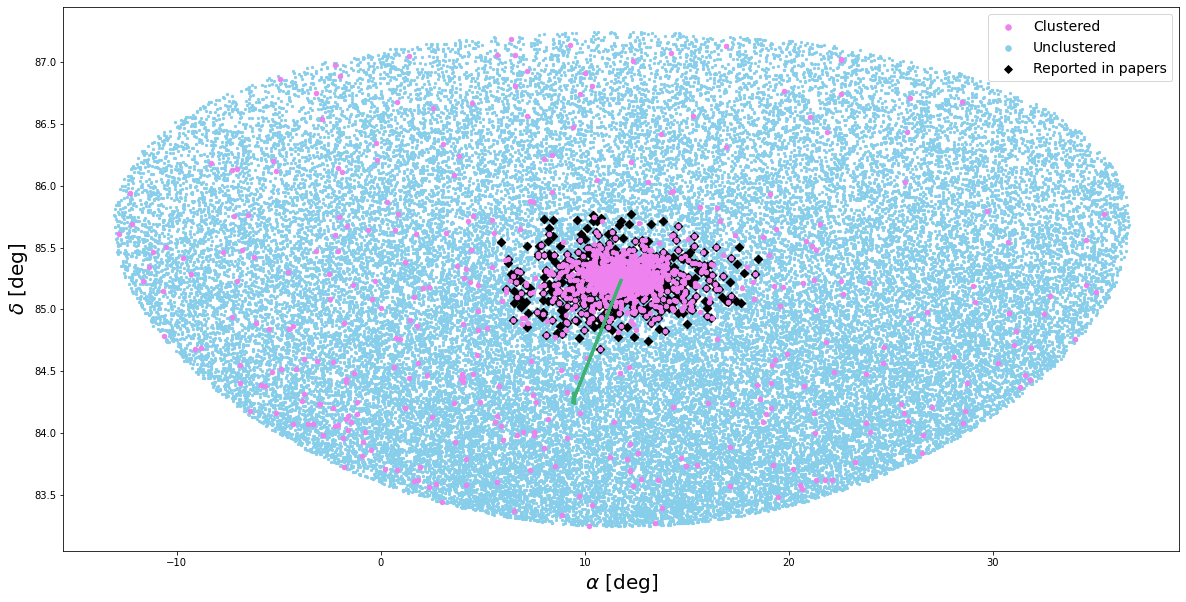

In [29]:
cluster_plot(clustered, gaiadr3, lit_dr3)
plt.arrow(cp_ra,
          cp_dec,
          cp_pmra,
          cp_pmdec,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

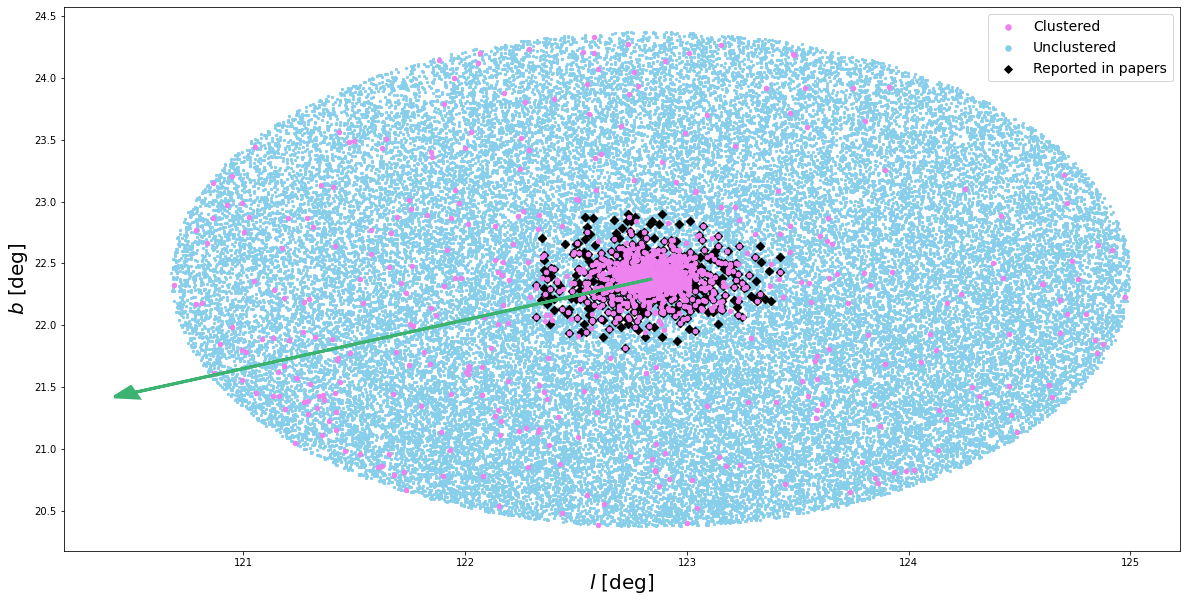

In [30]:
cluster_plot_galactic(clustered, gaiadr3, lit_dr3)
plt.arrow(galactic_coords.l.value,
          galactic_coords.b.value,
          galactic_coords.pm_l_cosb.value,
          galactic_coords.pm_b.value,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

In [ ]:
a = np.loadtxt('Trumpler 5_isochrone.dat', usecols=(28, 29, 30))

In [ ]:
plt.plot(a[:-1, 1]-a[:-1, 2], a[:-1, 0])
plt.gca().invert_yaxis();